# CIECAM02

In [1]:
from __future__ import division

import IPython.display
import PIL.Image
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot
import numpy as np
import scipy.ndimage
from cStringIO import StringIO
import warnings
    
import colour
from colour.plotting import *

colour.filter_warnings(True, False)


def array_plot(a, fmt='png'):
    buffer = StringIO()

    PIL.Image.fromarray(a).save(buffer, fmt)
    IPython.display.display(IPython.display.Image(data=buffer.getvalue()))
    

def auto_crop_array(a, keyer, threshold=0.01):
    a_c = np.copy(a).astype(np.float_)

    mask = np.abs(a - np.array([keyer, keyer, keyer])).sum(axis=2) < threshold

    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    return a[top_left[0]:bottom_right[0],
             top_left[1]:bottom_right[1]]

//anaconda/envs/colour-2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def lateral_brightness_adaptation(samples, background_colour):
    cp_1 = ColourParameter(RGB=samples[0])
    cp_2 = ColourParameter(RGB=samples[1])
    cp_3 = ColourParameter(RGB=samples[2])

    matplotlib.pyplot.clf()
    padding = 1
    figure = multi_colour_plot(
        [cp_1, cp_2, cp_3],
        height=2,
        spacing=padding,
        margins=(-padding, padding, -padding * 4, padding),
        background_colour=background_colour,
        standalone=False)

    for location in ('top', 'right', 'bottom', 'left'):
        figure.gca().spines[location].set_visible(False)
    figure.canvas.draw()

    lba = np.fromstring(figure.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    lba = lba.reshape(figure.canvas.get_width_height()[::-1] + (3,))
    lba = auto_crop_array(lba, 191)
    
    return lba


def lateral_brightness_adaptation_plot(samples):
    b_l = colour.oetf_sRGB(0.01)
    b_h = colour.oetf_sRGB(0.99)
    lba_w = lateral_brightness_adaptation(samples, (b_h, b_h, b_h))
    lba_r = lateral_brightness_adaptation(samples, (b_l, b_l, b_l))

    array_plot(colour.orient(colour.orient(
                np.vstack((colour.orient(lba_w, 'Flop'), lba_r)), '90 CW'), 'Flop'))

    XYZ = colour.sRGB_to_XYZ(samples, apply_decoding_cctf=True) * 100

    XYZ_w = np.array([95.05, 100.00, 108.88])
    L_A = 4
    Y_b = b_l * 100
    surround = colour.CIECAM02_VIEWING_CONDITIONS['Average']
    CIECAM02_s = colour.XYZ_to_CIECAM02(XYZ, XYZ_w, L_A, Y_b, surround, discount_illuminant=True)

    Y_b = b_h * 100
    XYZ_p = colour.CIECAM02_to_XYZ(
        CIECAM02_s.J,
        CIECAM02_s.C,
        CIECAM02_s.h,
        XYZ_w, L_A, Y_b, surround, discount_illuminant=True)
    samples = np.clip(colour.XYZ_to_sRGB(XYZ_p / 100, apply_encoding_cctf=True), 0, 1)

    lba_p = lateral_brightness_adaptation(samples, (b_h, b_h, b_h))

    array_plot(colour.orient(colour.orient(
                np.vstack((colour.orient(lba_p, 'Flop'), lba_r)), '90 CW'), 'Flop'))

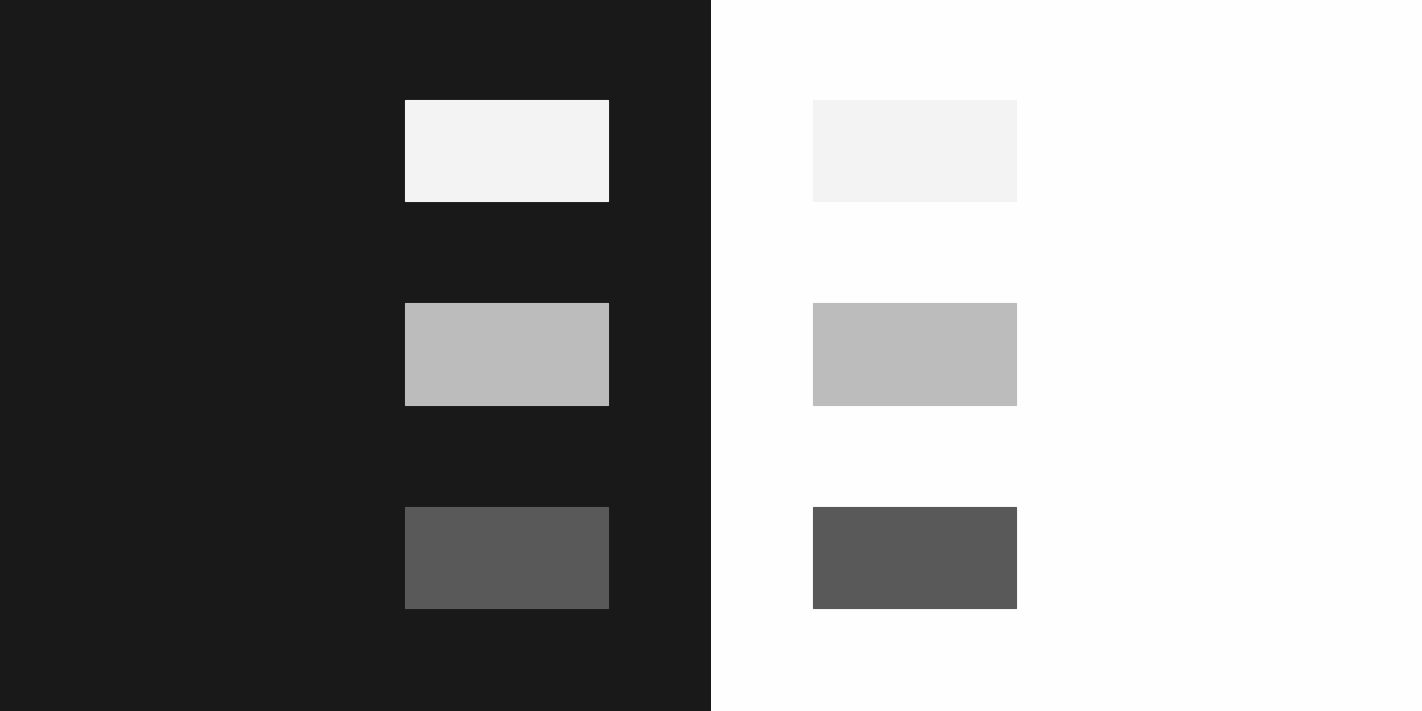

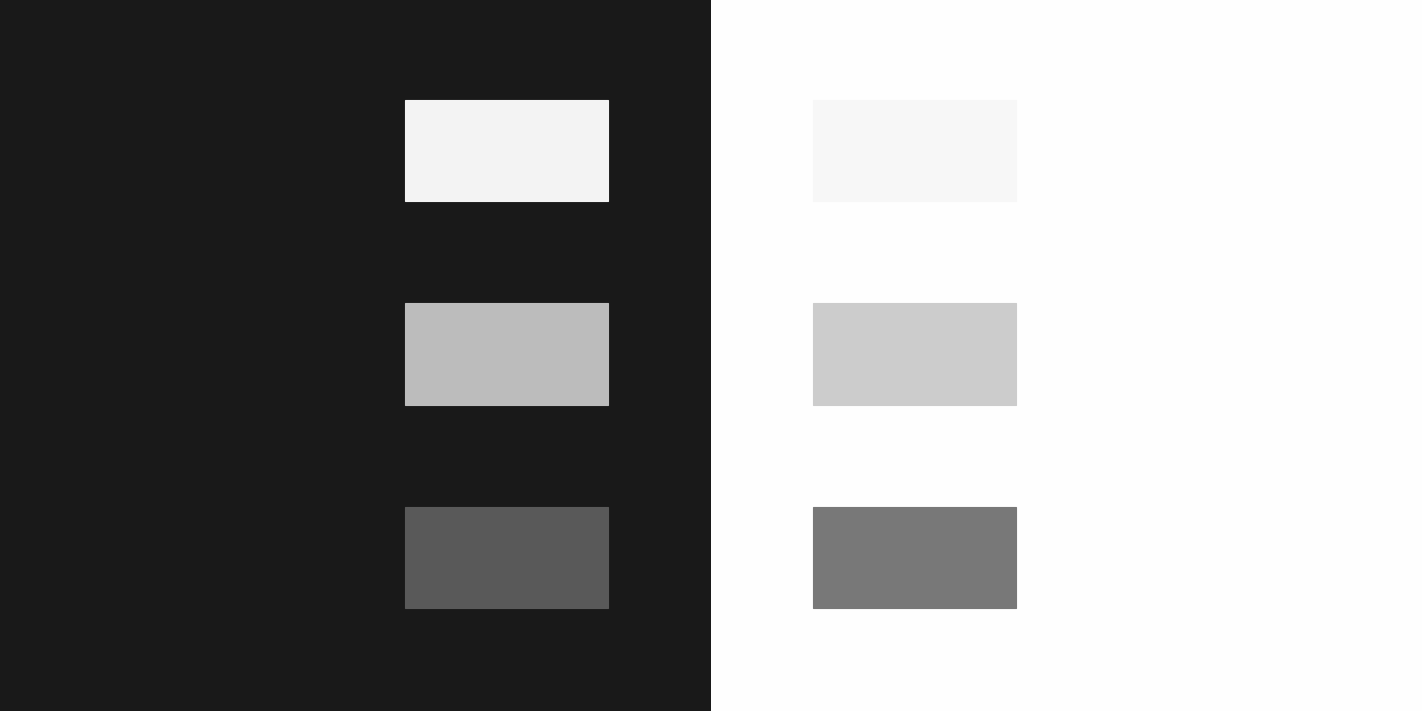

In [3]:
samples_c = 11
samples = colour.oetf_sRGB(np.linspace(0, 1, samples_c))
i_1, i_2, i_3 = 1, int(samples_c / 2), -2
samples = np.array([[samples[i_1], samples[i_1], samples[i_1]], 
                    [samples[i_2], samples[i_2], samples[i_2]],
                    [samples[i_3], samples[i_3], samples[i_3]]])

lateral_brightness_adaptation_plot(samples)

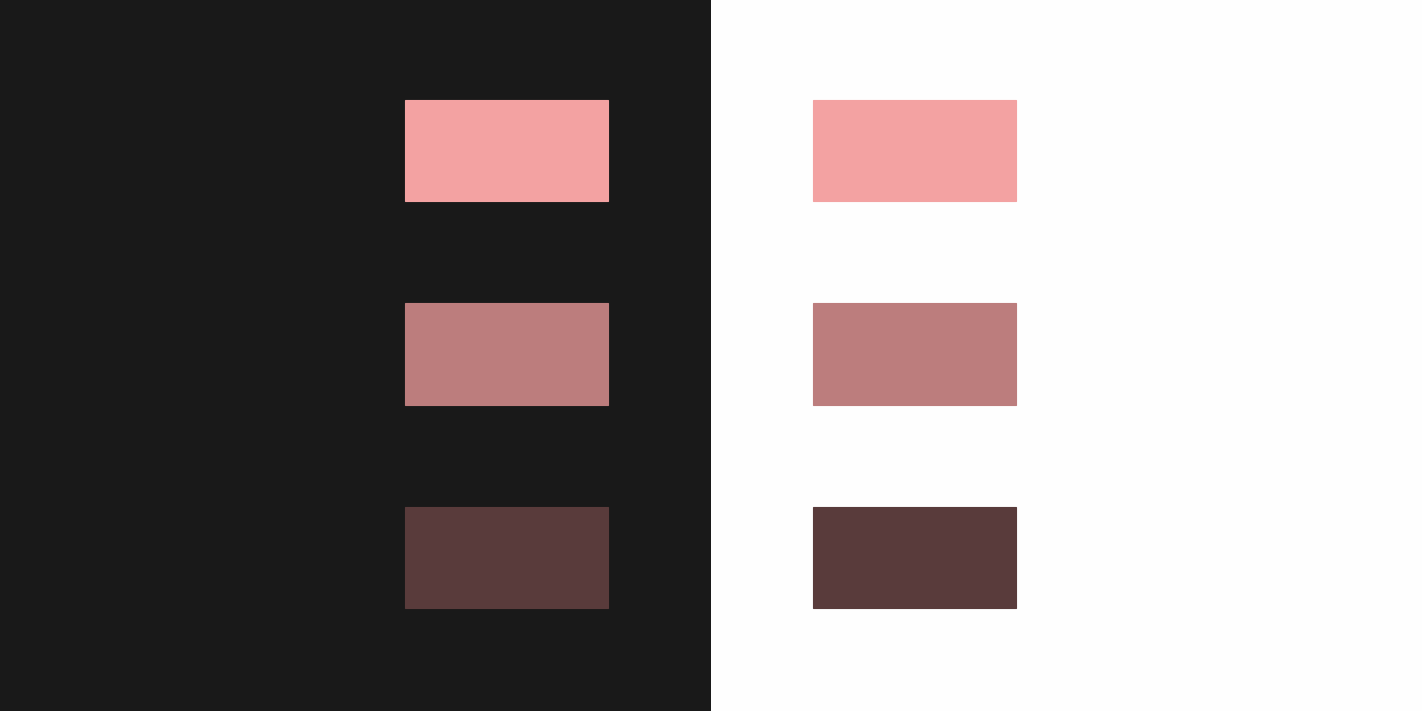

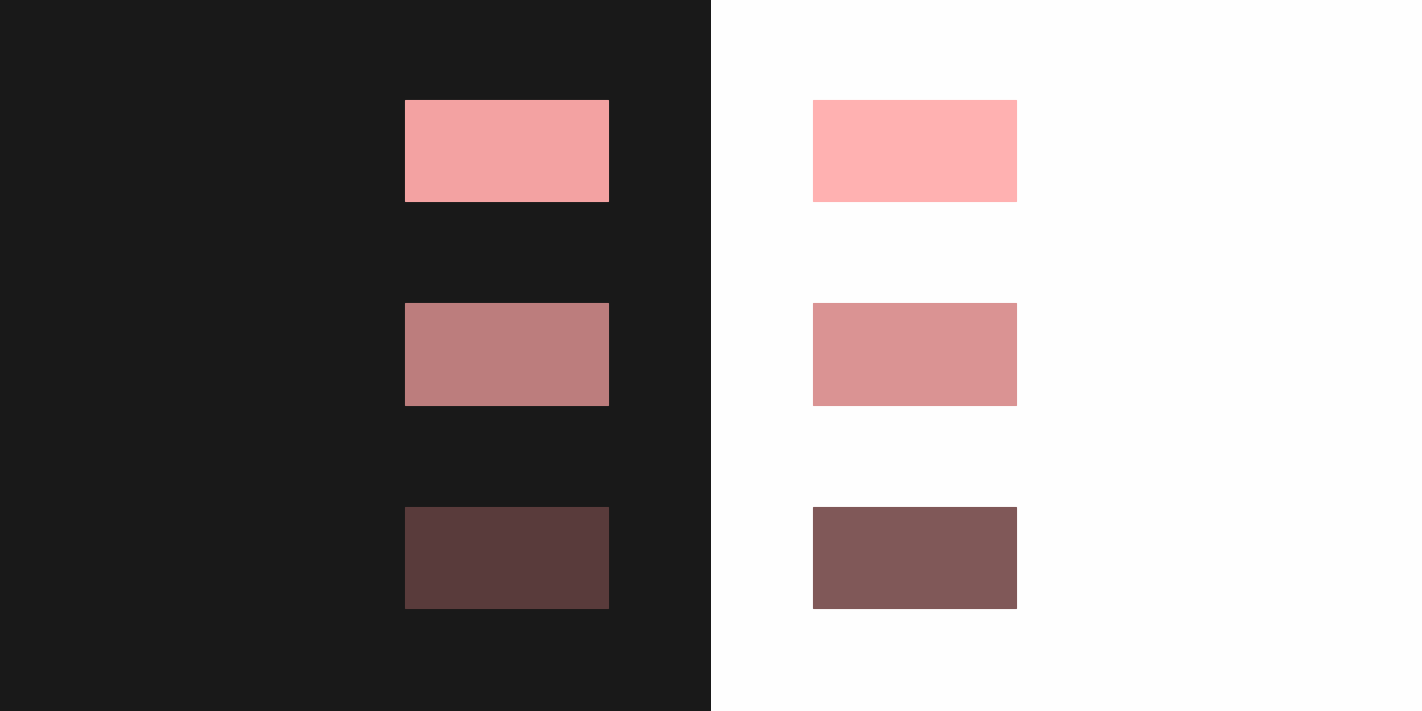

In [4]:
samples_r = np.copy(samples)
samples_r[:, 1:3] /= 1.5

lateral_brightness_adaptation_plot(samples_r)

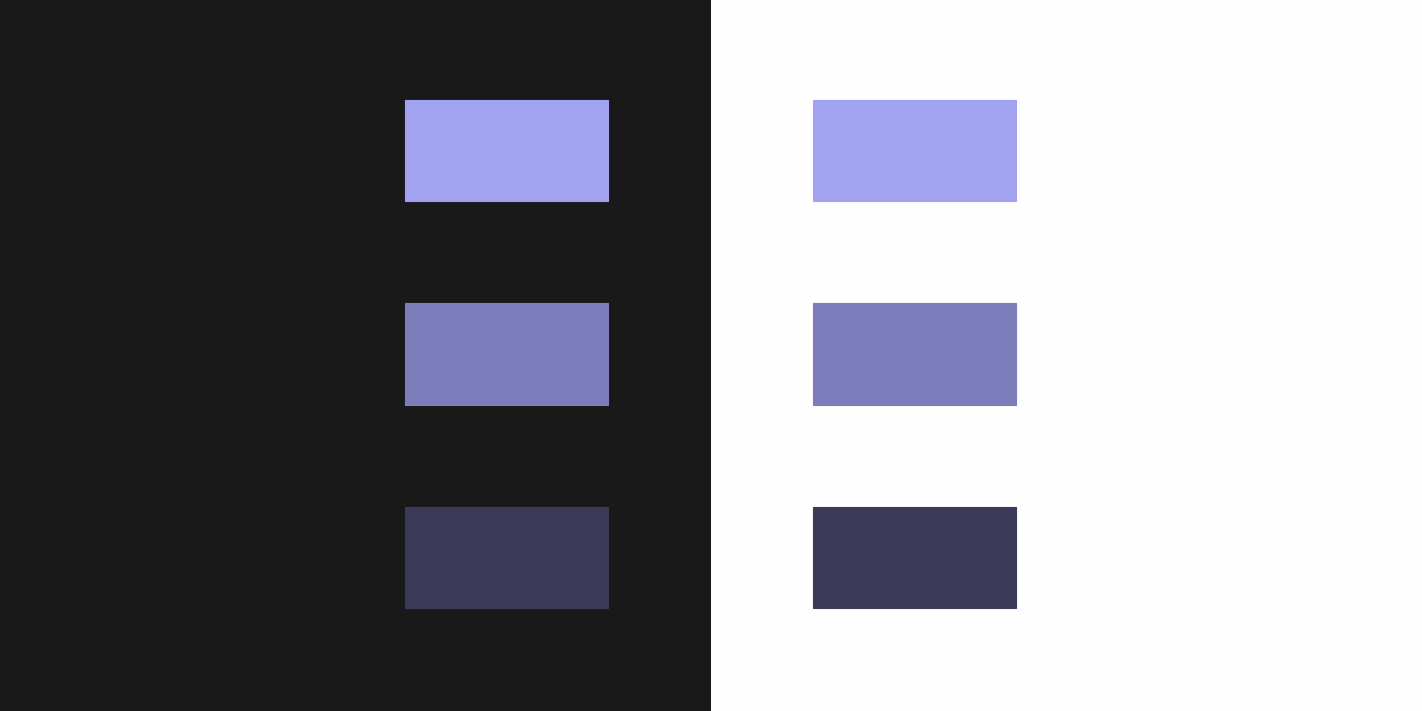

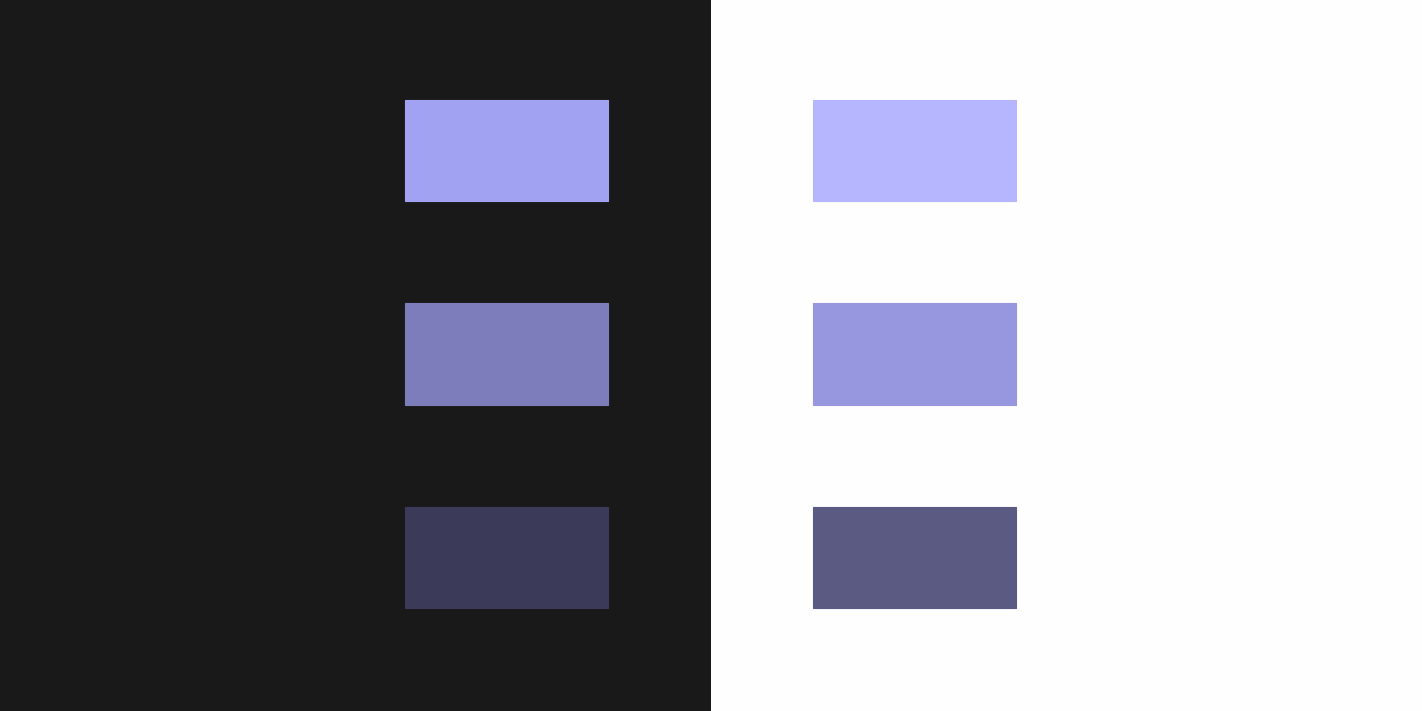

In [5]:
samples_b = np.copy(samples)
samples_b[:, 0:2] /= 1.5

lateral_brightness_adaptation_plot(samples_b)

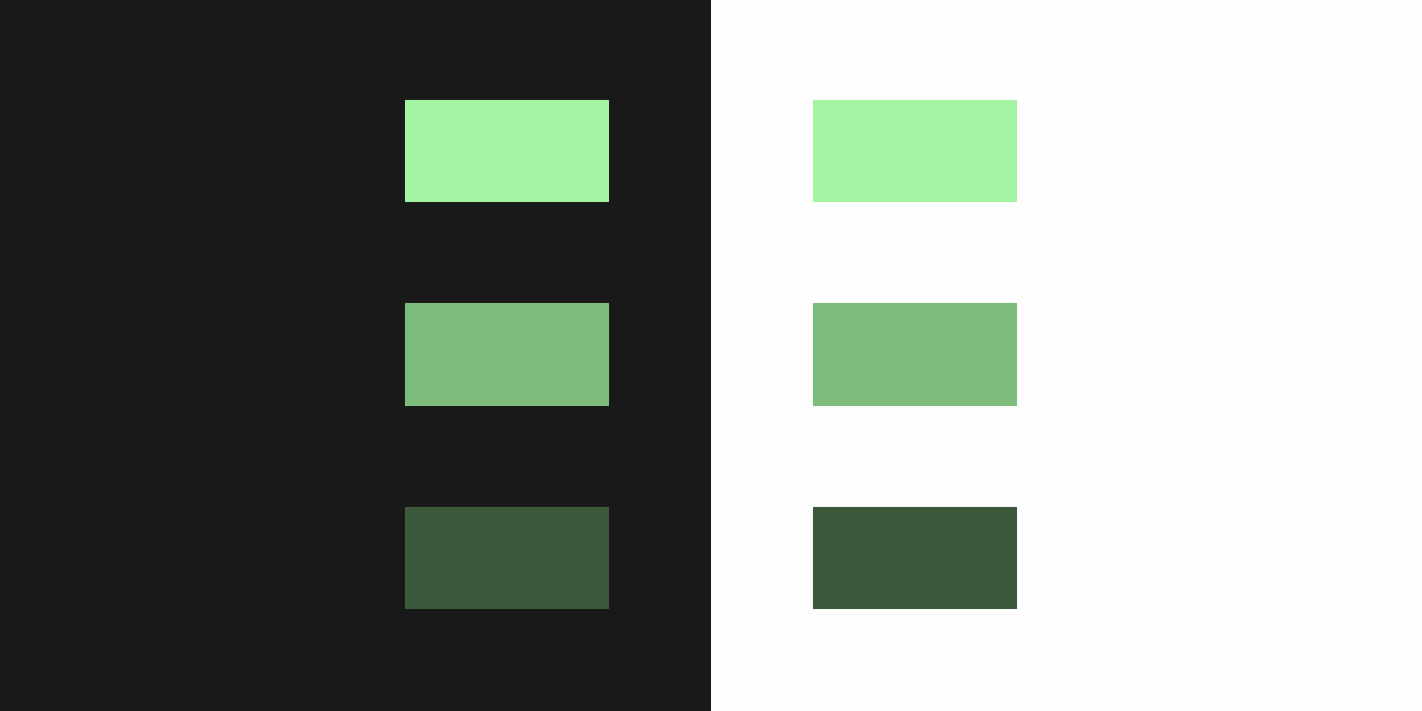

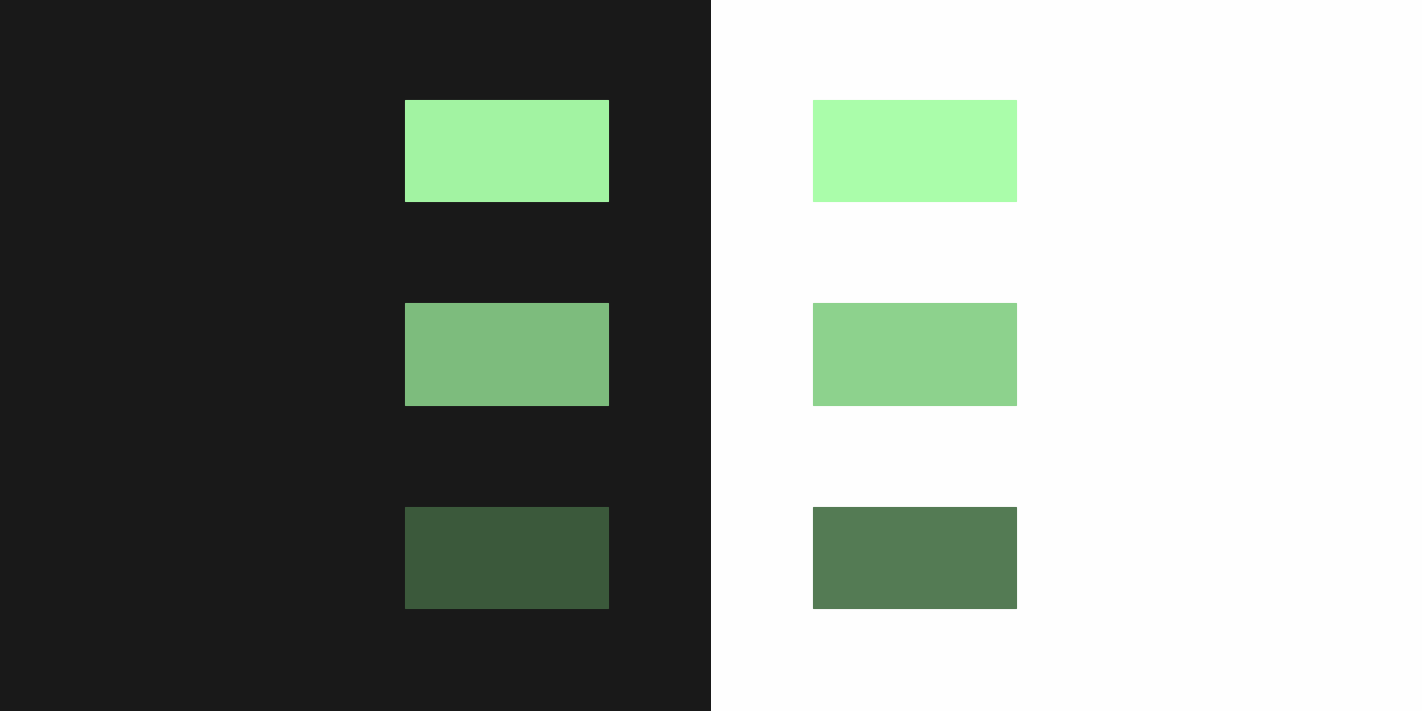

In [6]:
samples_g = np.copy(samples)
samples_g[:, 0] /= 1.5
samples_g[:, 2] /= 1.5

lateral_brightness_adaptation_plot(samples_g)